## Instalación de librerías en el entorno vitual.

In [1]:
!pip install lazypredict
!pip install seaborn

## Descarga y carga de datos
Se descarga el dataset desde GitHub, se extrae y se carga en dataframes.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import zipfile
import os
import requests
import lightgbm as lgb
from io import BytesIO
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from lazypredict.Supervised import LazyClassifier

# Descargar y extraer el dataset
data_url = "https://github.com/fjgr/IA_BigData/raw/refs/heads/main/dataset/terremotos_dataset.zip"
response = requests.get(data_url)
zip_file = zipfile.ZipFile(BytesIO(response.content))
zip_file.extractall("./data")

# Cargar los datos
train_values = pd.read_csv("./data/train_values.csv")
train_labels = pd.read_csv("./data/train_labels.csv")
test_values = pd.read_csv("./data/test_values.csv")

# Fusionar valores y etiquetas
train_data = train_values.merge(train_labels, on="building_id")

## Preprocesamiento de datos
Se rellenan valores faltantes, se codifican variables categóricas y se normalizan los datos.

In [4]:
# Seleccionar solo características numéricas, excluyendo la etiqueta 'damage_grade'
num_features = [col for col in train_data.select_dtypes(include=[np.number]).columns if col != "damage_grade"]

# Rellenar valores faltantes con la mediana
train_data[num_features] = train_data[num_features].fillna(train_data[num_features].median())
test_values[num_features] = test_values[num_features].fillna(test_values[num_features].median())

# Codificación de variables categóricas con OneHotEncoder
categorical_features = ["foundation_type", "roof_type", "ground_floor_type", "other_floor_type"]
train_data = pd.get_dummies(train_data, columns=categorical_features)
test_values = pd.get_dummies(test_values, columns=categorical_features)

# Asegurar que train y test tengan las mismas columnas
train_data, test_values = train_data.align(test_values, join='left', axis=1, fill_value=0)


## Selección de características con dendrograma
Se genera un dendrograma para visualizar relaciones entre variables.

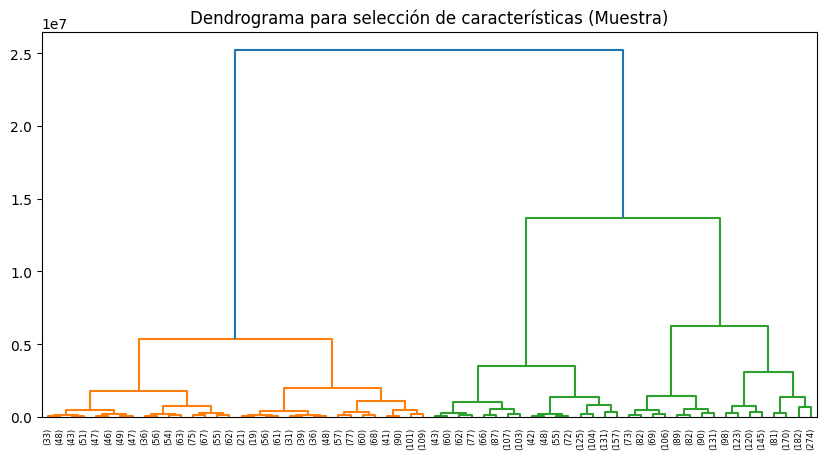

In [6]:
# Reducir el número de datos para calcular el dendrograma (5,000 filas aleatorias)
sample_data = train_data[num_features].sample(n=5000, random_state=42)

# Calcular el linkage sobre la muestra reducida
Z = linkage(sample_data, method='ward')

# Graficar el dendrograma
plt.figure(figsize=(10, 5))
dendrogram(Z, truncate_mode='level', p=5)
plt.title("Dendrograma para selección de características (Muestra)")
plt.show()


## División en entrenamiento y prueba
Se dividen los datos en conjunto de entrenamiento y validación.

In [7]:
selected_features = ["geo_level_1_id", "geo_level_2_id", "geo_level_3_id", "age", "area_percentage", "height_percentage"]
selected_features += [col for col in train_data.columns if "has_superstructure" in col]
selected_features += ["count_floors_pre_eq", "position", "plan_configuration"]
X = train_data[selected_features]
y = train_data["damage_grade"]

# Codificación LabelEncoder para variables categóricas adicionales
le = LabelEncoder()
for col in ["position", "plan_configuration"]:
    X[col] = le.fit_transform(X[col])
    test_values[col] = test_values[col].map(lambda x: le.transform([x])[0] if x in le.classes_ else -1)

# División en conjuntos de entrenamiento y validación
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Entrenamiento de modelos y optimización de hiperparámetros
Se entrenan varios modelos de machine learning y se optimizan con RandomizedSearchCV.

In [8]:
models = {
    "Random Forest": RandomForestClassifier(class_weight='balanced'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "Extra Trees": ExtraTreesClassifier(class_weight='balanced'),
    "LGBM": lgb.LGBMClassifier(),
    "SVM": SVC(kernel='rbf', C=1, probability=True)
}

param_grid = {
    "LGBM": {
        "n_estimators": [300, 500, 700],
        "learning_rate": [0.05, 0.1, 0.2],
        "num_leaves": [20, 31, 50],
        "max_depth": [-1, 10, 20]
    }
}

best_models = {}
for name, model in models.items():
    if name in param_grid:
        search = RandomizedSearchCV(model, param_grid[name], cv=5, scoring='f1_micro', n_iter=10, random_state=42)
        search.fit(X_train, y_train)
        best_models[name] = search.best_estimator_
    else:
        model.fit(X_train, y_train)
        best_models[name] = model


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008932 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 166784, number of used features: 20
[LightGBM] [Info] Start training from score -2.339123
[LightGBM] [Info] Start training from score -0.564034
[LightGBM] [Info] Start training from score -1.094585
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008356 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 720
[LightGBM] [Info] Number of data points in the train set: 166784, number of used features: 20
[LightGBM] [Info] Start training from score -2.339185
[LightGBM] [Info] Start training from score -0.564023
[LightGBM] [Info] Start 

## Evaluación de modelos y visualización de resultados
Se evalúan los modelos usando métricas de clasificación y se visualiza la matriz de confusión.

Random Forest Classification Report:
              precision    recall  f1-score   support

           1       0.61      0.48      0.54      5025
           2       0.72      0.81      0.76     29652
           3       0.71      0.61      0.66     17444

    accuracy                           0.71     52121
   macro avg       0.68      0.63      0.65     52121
weighted avg       0.71      0.71      0.71     52121



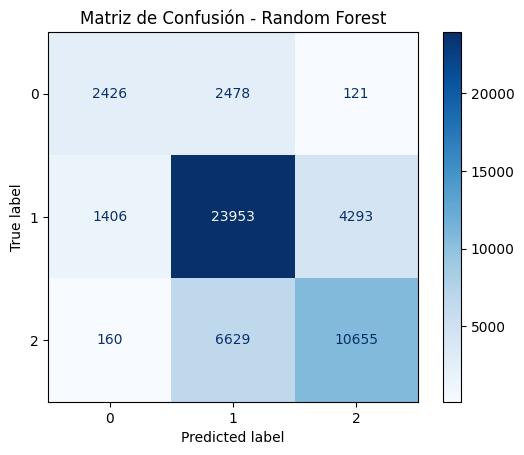

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           1       0.62      0.36      0.45      5025
           2       0.67      0.86      0.75     29652
           3       0.72      0.46      0.56     17444

    accuracy                           0.68     52121
   macro avg       0.67      0.56      0.59     52121
weighted avg       0.68      0.68      0.66     52121



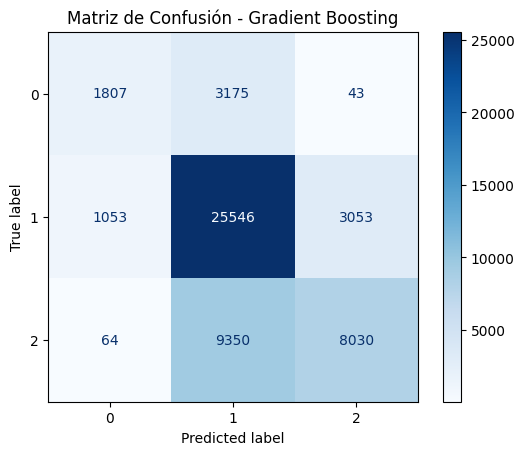

Extra Trees Classification Report:
              precision    recall  f1-score   support

           1       0.57      0.51      0.54      5025
           2       0.73      0.77      0.75     29652
           3       0.68      0.63      0.66     17444

    accuracy                           0.70     52121
   macro avg       0.66      0.64      0.65     52121
weighted avg       0.70      0.70      0.70     52121



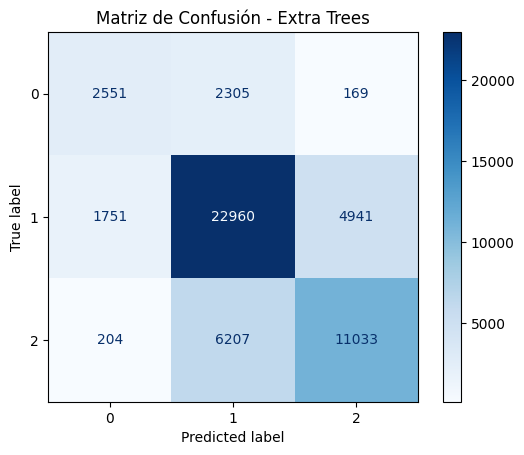

LGBM Classification Report:
              precision    recall  f1-score   support

           1       0.68      0.51      0.58      5025
           2       0.74      0.85      0.79     29652
           3       0.76      0.63      0.69     17444

    accuracy                           0.74     52121
   macro avg       0.73      0.66      0.69     52121
weighted avg       0.74      0.74      0.74     52121



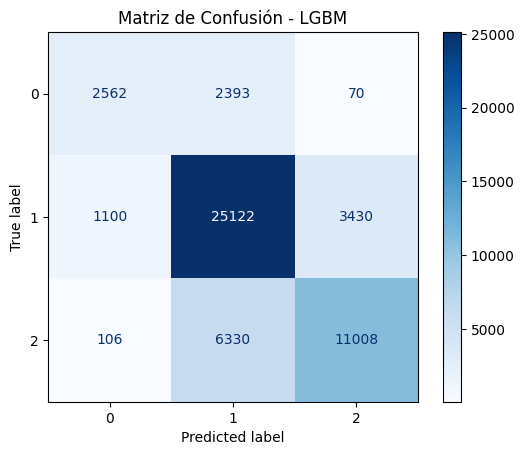

SVM Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00      5025
           2       0.57      1.00      0.73     29652
           3       0.00      0.00      0.00     17444

    accuracy                           0.57     52121
   macro avg       0.19      0.33      0.24     52121
weighted avg       0.32      0.57      0.41     52121



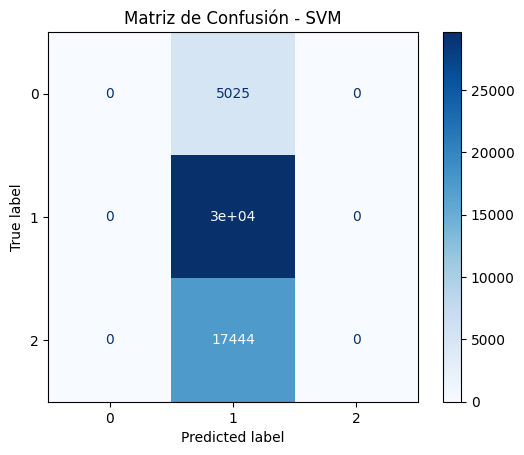

In [9]:
y_preds = {name: model.predict(X_valid) for name, model in best_models.items()}
for name, y_pred in y_preds.items():
    print(f"{name} Classification Report:\n{classification_report(y_valid, y_pred)}")
    cm = confusion_matrix(y_valid, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap="Blues")
    plt.title(f"Matriz de Confusión - {name}")
    plt.show()

### Implementación de Voting Classifier
Se combina los mejores modelos en un clasificador de votación para mejorar la precisión.

In [10]:
voting_clf = VotingClassifier(
    estimators=[
        ("LGBM", best_models["LGBM"]),
        ("Random Forest", best_models["Random Forest"]),
        ("Gradient Boosting", best_models["Gradient Boosting"])
    ],
    voting="soft"
)
voting_clf.fit(X_train, y_train)
y_pred_voting = voting_clf.predict(X_valid)
print("Voting Classifier Report:\n", classification_report(y_valid, y_pred_voting))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011393 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 725
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 20
[LightGBM] [Info] Start training from score -2.339173
[LightGBM] [Info] Start training from score -0.564028
[LightGBM] [Info] Start training from score -1.094582
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Voting Classifier Report:
               precision    recall  f1-score   support

           1       0.69      0.46      0.55      5025
           2       0.73      0.86      0.79     29652
           3       0.77      0.60      0.67     17444

    accuracy                           0.74     52121
   macro avg       0.73      0.64      0.67     52121
weighted avg       0.74      0.74      0.73     52121



### Evaluación con Lazy Predict
Se usa `LazyClassifier` para comparar rápidamente múltiples modelos.

In [11]:
lazy = LazyClassifier()
models_lazy, predictions_lazy = lazy.fit(X_train, X_valid, y_train, y_valid)
print(models_lazy)

 97%|█████████▋| 31/32 [1:17:06<06:56, 416.48s/it]   

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011063 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 739
[LightGBM] [Info] Number of data points in the train set: 208480, number of used features: 20
[LightGBM] [Info] Start training from score -2.339173
[LightGBM] [Info] Start training from score -0.564028
[LightGBM] [Info] Start training from score -1.094582


100%|██████████| 32/32 [1:17:08<00:00, 144.63s/it]

                               Accuracy  Balanced Accuracy ROC AUC  F1 Score  \
Model                                                                          
BaggingClassifier                  0.70               0.64    None      0.70   
ExtraTreesClassifier               0.71               0.64    None      0.70   
RandomForestClassifier             0.72               0.64    None      0.71   
DecisionTreeClassifier             0.66               0.61    None      0.66   
LGBMClassifier                     0.71               0.61    None      0.70   
ExtraTreeClassifier                0.65               0.60    None      0.65   
KNeighborsClassifier               0.66               0.60    None      0.66   
NearestCentroid                    0.46               0.55    None      0.43   
QuadraticDiscriminantAnalysis      0.42               0.54    None      0.33   
GaussianNB                         0.41               0.51    None      0.32   
BernoulliNB                        0.58 

## Generación de predicciones y archivo de salida
Se genera el archivo CSV con las predicciones finales.

In [12]:
final_model = best_models["LGBM"]
final_predictions = final_model.predict(test_values[selected_features])
submission = pd.DataFrame({"building_id": test_values["building_id"], "damage_grade": final_predictions})
submission.to_csv("submission.csv", index=False)